In [ ]:
!pip install discretize==0.10.0 #differ from the 0.8.3
!pip install SimPEG==0.19
!pip install pymatsolver==0.2.0
!pip install utm==0.7.0

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from os import listdir
import torch.optim as optim

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tarfile
import utm
from discretize import TreeMesh, TensorMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz

from SimPEG.utils import model_builder
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
)
from SimPEG.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc
from SimPEG.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

mpl.rcParams.update({"font.size": 16})
# sphinx_gallery_thumbnail_number = 4

/tmp/ipykernel_3154070/3040355382.py:11: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG.utils import model_builder


In [3]:
from matplotlib.colors import Colormap
import pymatsolver
from SimPEG.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    apparent_resistivity_from_voltage,
    plot_pseudosection,
)

Mesh Design

In [6]:
# Cell sizes
csx, csy = 5.0, 5.0
# Number of core cells in each direction
ncx, ncy = 200.0 , 45.0
# Number of padding cells to add in each direction
npad = 7
# Vectors of cell lengths in each direction with padding
hx_ = [(csx, npad, -1.5), (csx, ncx), (csx, npad, 1.5)]
hy_ = [(csy, npad, -1.5), (csy, ncy)]
# Create mesh and center it
mesh = TensorMesh([hx_, hy_], x0="CN")




In [7]:
mesh

TensorMesh: 11,128 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    214       -741.29        741.29      5.00     85.43    1.50
   y     52       -466.29          0.00      5.00     85.43    1.50

/tmp/ipykernel_3154070/2300458564.py:1: FutureWarning: TensorMesh.plotGrid has been deprecated, please use TensorMesh.plot_grid. It will be removed in version 1.0.0 of discretize.
  mesh.plotGrid()


<AxesSubplot:xlabel='x1', ylabel='x2'>

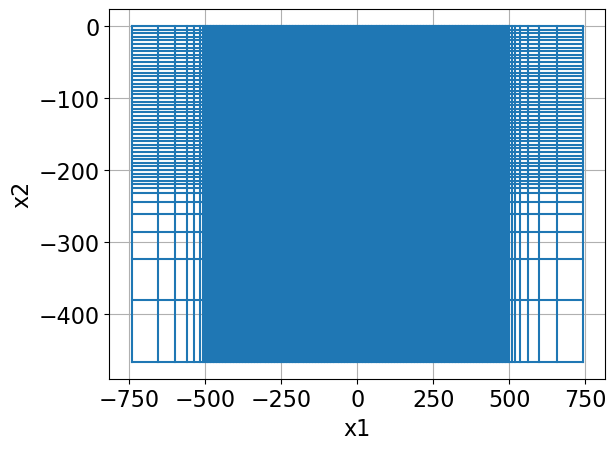

In [8]:
mesh.plotGrid()

In [9]:
_ind_active = np.ones((45,200))
_ind_active = np.pad(_ind_active, ((7,0),(7,7)),  constant_values=(0, 0))
ind_active_=[]
for i in _ind_active.flatten():
  if i == 1.:
    ind_active_.append(True)
  else:
    ind_active_.append(False)
ind_active_=np.array(ind_active_)
background_conductivity = np.log(1e-2)
active_map = maps.InjectActiveCells(mesh, ind_active_, np.exp(background_conductivity))

In [10]:
nC = int(ind_active_.sum()) # Number of cells below the surface< ind_active.shape[0]
conductivity_map = active_map * maps.ExpMap()

Load Results file

In [13]:
import pickle
# n_ = open("./NF_3_1/test_final.pkl", 'rb')
n_ = open("../NF_6_28_1/test_final.pkl", 'rb')
m_ = pickle.load(n_)
n_.close()

Plot results

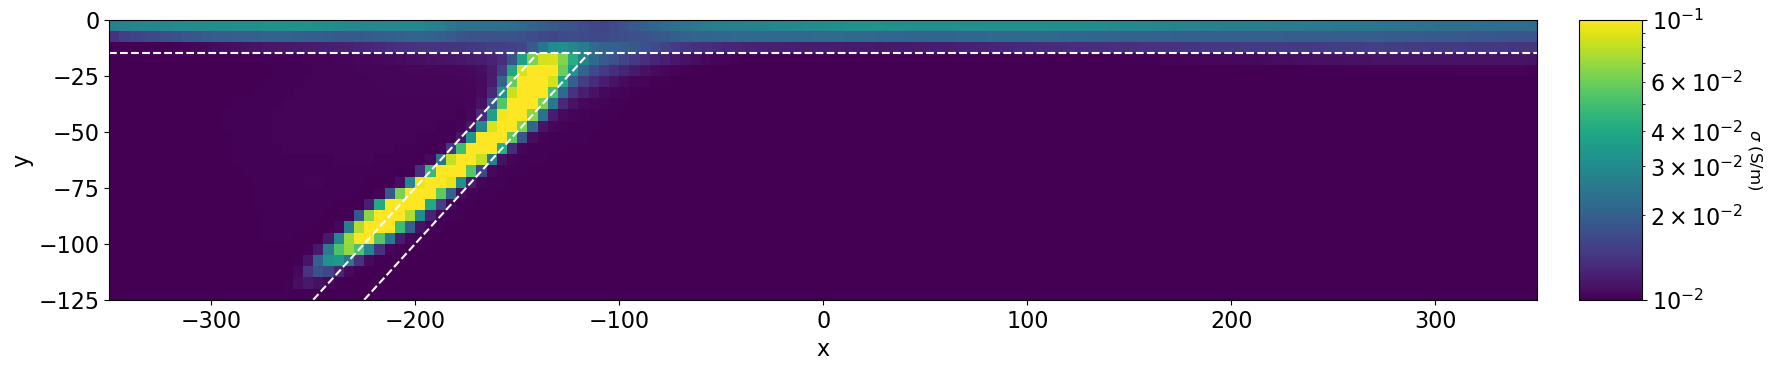

In [20]:
fig = plt.figure(figsize=(21, 4))
norm = LogNorm(vmin=1e-2, vmax=1e-1)
recovered_conductivity = conductivity_map * m_
ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    recovered_conductivity, normal="Y", ax=ax1, grid=False, pcolor_opts={"norm": norm}, ncontour=1
)
ax1.set_xlim(-350, 350)
ax1.set_ylim(-125, 0)
ax1.plot(np.linspace(-350,350, 1000), -15*np.ones(1000), "w--")
ax1.plot(np.linspace(-125,-15, 1000)-100, np.linspace(-125,-15, 1000), "w--")
ax1.plot(np.linspace(-125,-15, 1000)-125, np.linspace(-125,-15, 1000), "w--")
ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

plt.show()

